In [1]:
import os
import json

import pandas as pd
import numpy as np

import networkx as nx
from graph_encoders import *

from linear_algebra_utils import *
from digraph_algorithms import *
from quiver_pca import *
from pca_utils import *

from sklearn.decomposition import PCA

In [2]:
X_train = pd.read_csv('../data/crop_mapping/nodewise_PCA_train.csv')
X_test = pd.read_csv('../data/crop_mapping/nodewise_PCA_test.csv')

with open('../data/crop_mapping/reduced_nodes.json', 'r') as file:
    all_node_columns = json.load(file)
all_nodes = all_node_columns.keys()

In [3]:
X_train_subspaces = {node: X_train[all_node_columns[node]] for node in all_nodes}
X_test_subspaces = {node: X_test[all_node_columns[node]] for node in all_nodes}

In [4]:
quiver_rep_directory = '../data/crop_mapping/quiver_reps/'
quiver_reps = []

for file_path in os.listdir(quiver_rep_directory):
    if file_path.endswith('.json'):
        with open(f"{quiver_rep_directory}{file_path}", 'r') as file:
            quiver_reps.append(
                json.load(file, cls=NetworkXQuiverRepresentationDecoder)
            )

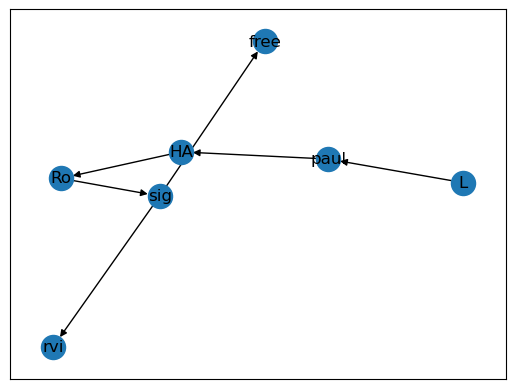

In [5]:
Q = quiver_reps[0]
nx.draw_networkx(Q)

In [6]:
'''
Project data onto distinguished subspaces constructed from quiver representations.
For each quiver:
    1. Calculate the space of sections
    2. Project data onto the space of sections
    3. Further reduce dimension by applying (classical) PCA
'''

X_train_quiver_projections = []
X_test_quiver_projections = []
k = len(quiver_reps)
for i in range(k):
    print(f"Getting projected data from quiver Q{i:02}...")
    Q = quiver_reps[i]
    Q_nodes = list(Q.nodes)
    Q_node_columns = {node: all_node_columns[node] for node in Q_nodes}

    X_Q_train = pd.concat([X_train_subspaces[node] for node in Q_nodes],axis=1)
    X_Q_test = pd.concat([X_test_subspaces[node] for node in Q_nodes],axis=1)

    Qplus = augment_DAG_with_root(Q)
    generate_space_of_sections(Qplus)
    sections = Qplus.graph['sections']
    normalized_sections = orthogonalize_section_basis(sections, Q_node_columns)


    X_Q_proj_train = [project_onto_subspace(X_Q_train.iloc[i], normalized_sections) for i in range(len(X_Q_train))]
    X_Q_proj_train = pd.concat(X_Q_proj_train, axis=1).T
    X_Q_proj_test = [project_onto_subspace(X_Q_test.iloc[i], normalized_sections) for i in range(len(X_Q_test))]
    X_Q_proj_test = pd.concat(X_Q_proj_test, axis=1).T

    
    X_Q_PCA_train, X_Q_PCA_test = top_principal_components(
        X_Q_proj_train, X_Q_proj_test,
        name=f"Q{i:02}",
        use_threshold=True
    )

    X_train_quiver_projections.append(X_Q_PCA_train)
    X_test_quiver_projections.append(X_Q_PCA_test)
X_quiver_invariant_train = pd.concat(X_train_quiver_projections, axis=1)
X_quiver_invariant_test = pd.concat(X_test_quiver_projections, axis=1)
print('Projections onto sections complete!')

Getting projected data from quiver Q00...
Getting projected data from quiver Q01...
Getting projected data from quiver Q02...
Getting projected data from quiver Q03...
Getting projected data from quiver Q04...
Getting projected data from quiver Q05...
Getting projected data from quiver Q06...
Getting projected data from quiver Q07...
Getting projected data from quiver Q08...
Getting projected data from quiver Q09...
Getting projected data from quiver Q10...
Projections onto sections complete!


In [7]:
X_quiver_invariant_train.head()

,Q00_0,Q00_1,Q00_2,Q01_0,Q01_1,Q01_2,Q01_3,Q02_0,Q02_1,Q02_2,...,Q07_2,Q08_0,Q08_1,Q09_0,Q09_1,Q09_2,Q09_3,Q10_0,Q10_1,Q10_2
0,3.326407,-1.733751,-2.210721,-3.687704,-1.064910,1.521897,0.758622,-2.511852,-0.830138,-1.649082,...,-0.863941,0.225260,0.115779,-4.217820,-0.417962,-1.097858,-0.409132,-2.868749,-0.821512,-1.212595
1,-1.615321,4.181650,-0.709892,-1.136849,3.035028,-2.384765,-0.036497,-0.435655,-2.116353,0.925021,...,0.584283,2.370593,-1.400690,3.514444,-3.064772,0.433171,-0.172408,2.441274,-2.449367,0.742637
2,0.294562,-1.891156,-0.977767,1.038646,-0.682370,1.194165,-0.524364,0.337365,-0.283093,-0.824976,...,-0.442157,0.010138,0.166149,-1.174316,0.997001,0.326497,-0.190623,-0.652386,0.585564,0.221223
3,-1.683926,4.186944,-0.706492,-1.094435,2.962918,-2.438787,0.189396,-0.384979,-2.084991,0.883077,...,0.649383,2.349911,-1.214803,3.519123,-2.978593,0.281801,-0.007736,2.407250,-2.316978,0.612909
4,-0.969671,4.120698,-0.945859,-2.033153,2.852389,-2.162776,0.082540,-1.025187,-2.184163,0.750711,...,0.444751,2.294931,-1.451703,2.739928,-3.222531,0.251229,-0.313548,1.810715,-2.699461,0.537182


In [8]:
X_quiver_invariant_train.to_csv('../data/crop_mapping/quiver_invariant_train.csv', mode='w', index=False)
X_quiver_invariant_test.to_csv('../data/crop_mapping/quiver_invariant_test.csv', mode='w', index=False)